In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import teotil3 as teo
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Task 2.15: Testing, documentation and reporting

## Part A: Compare TEOTIL2 versus TEOTIL3

This notebook explores the input and output files generated by the new model, including comparison to TEOTIL2.

## 1. Generate input files

Aggregated model inputs for each regine can be generated from the "raw" data in the TEOTIL3 database.

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


In [4]:
nve_data_year = 2022
st_yr, end_yr = 2013, 2021
out_csv_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data_compat_teo2"

In [5]:
%%time

# Generate input files
years = range(st_yr, end_yr + 1)
for year in tqdm(years):
    gdf = teo.io.make_input_file(
        year,
        nve_data_year,
        eng,
        out_csv_fold=out_csv_fold,
        nan_to_vass=True,
        add_offshore=True,
        order_coastal=True,  # Recommend False, excpet for comparison with TEOTIL2
        land_to_vass=False,  # Recommend True, excpet for comparison with TEOTIL2
    )

  0%|          | 0/9 [00:00<?, ?it/s]

100.00 % of regines assigned.
100.00 % of regines assigned.
100.00 % of regines assigned.
100.00 % of regines assigned.
100.00 % of regines assigned.
100.00 % of regines assigned.
100.00 % of regines assigned.
100.00 % of regines assigned.
100.00 % of regines assigned.
CPU times: user 3min 38s, sys: 6.56 s, total: 3min 45s
Wall time: 5min 11s


In [6]:
# Merge all TEOTIL3 inputs to a single df
df_list = []
years = range(st_yr, end_yr + 1)
for year in tqdm(years):
    fpath = os.path.join(
        out_csv_fold,
        f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
    )
    df = pd.read_csv(fpath)
    df["year"] = year
    df_list.append(df)

df = pd.concat(df_list, axis="rows")
df.head()

  0%|          | 0/9 [00:00<?, ?it/s]

,regine,regine_down,a_cat_land_km2,runoff_mm/yr,q_cat_m3/s,trans_totp,trans_tdp,trans_tpp,trans_totn,trans_din,...,agriculture-background_totp_kg,agriculture_tdp_kg,agriculture-background_tdp_kg,agriculture_tpp_kg,agriculture-background_tpp_kg,agriculture_toc_kg,agriculture-background_toc_kg,agriculture_ss_kg,agriculture-background_ss_kg,year
0,001.10,001.,1.160850,532.0,0.019586,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.00000,2013
1,001.1A1,001.10,1.432412,558.0,0.025306,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.00000,2013
2,001.1A20,001.1A1,0.340114,534.0,0.005755,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.00000,2013
3,001.1A2A,001.1A20,17.647822,573.0,0.320352,1.000000,1.000000,1.000000,1.000000,1.000000,...,24.232893,64.488807,7.269868,244.788346,16.963025,0.0,22564.3252,148418.3240,11476.83830,2013
4,001.1A2B,001.1A2A,41.298255,573.0,0.749662,0.142596,0.596243,0.014095,0.247332,0.189505,...,19.123508,48.555228,5.737052,133.315182,13.386455,0.0,18735.8040,78839.9211,9064.66046,2013


## 2. Compare discharge time series

Compare the annual discharges modelled by TEOTIL3 to those supplied by NVE.

**Note:** The data supplied by NVE are poor in some areas - see the e-mail from Stein Beldring received 09.10.2022 and the issue [here](https://github.com/NIVANorge/teotil3/issues/15) for details. The new workflow uses NVE's new runoff "normal" for 1991 to 2020, which should give better results. In the code below, I therefore mostly want to check that the temporal patterns in the TEOTIL series are the same as in the NVE series, and that the magnitudes are reasonable.

In [7]:
# Get annual modelled flows for each vassom from TEOTIL
df["vassom"] = df["regine"].str.split(".", n=1).str[0]
agg_df = (
    df.groupby(["vassom", "year"]).sum(numeric_only=True)["q_cat_m3/s"].reset_index()
)

# Get data from NVE
sql = f"""
    SELECT 
        vassom, 
        DATE_PART('year', date)::INT AS year, 
        AVG("flow_m3/s") AS "nve_flow_m3/s"
    FROM teotil3.nve_hbv_discharge
    WHERE data_supply_year = {nve_data_year}
    GROUP BY vassom, year
    ORDER BY vassom, year
    """
nve_df = pd.read_sql(sql, eng)

# Join
q_df = pd.merge(agg_df, nve_df, how="left", on=["vassom", "year"])
q_df.head()

,vassom,year,q_cat_m3/s,nve_flow_m3/s
0,001,2013,38.292191,31.887461
1,001,2014,57.124336,47.569752
2,001,2015,52.457491,43.683483
3,001,2016,32.068238,26.704522
4,001,2017,29.825550,24.836945


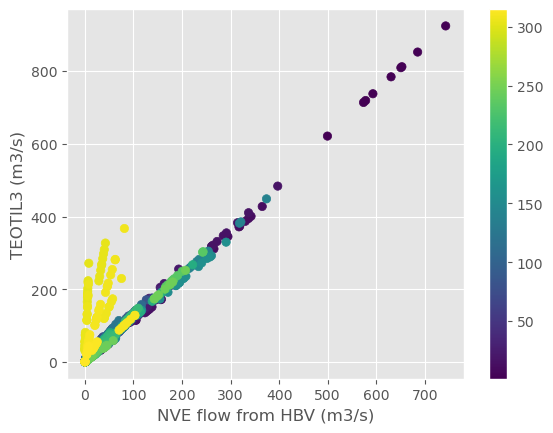

In [8]:
plt.scatter(q_df["nve_flow_m3/s"], q_df["q_cat_m3/s"], c=q_df["vassom"].astype(int))
plt.xlabel("NVE flow from HBV (m3/s)")
plt.ylabel("TEOTIL3 (m3/s)")
plt.colorbar()

The scatterplot above seems reasonable. The TEOTIL flows are generally higher than those from HBV, but I have good reason to believe HBV underestimates flows in many areas. The only areas that are *really* different are for regines bordering Sweden, where the HBV data stops, whereas TEOTIL estimates flows from whole regines (including portions in Sweden).

Let's check a few specific vassdragsområder. I know from [this issue](https://github.com/NIVANorge/teotil3/issues/15) that HBV works OK for Glomma, so I expect the two methods to be fairly similar there. Note that Wikipedia gives the mean observed flow at Glomma to be 720 m3/s, which is closer to the new TEOTIL results than to HBV.

In [9]:
vassom_002_df = q_df.query("vassom == '002'").set_index("year")
del vassom_002_df["vassom"]
display(vassom_002_df.mean())
# vassom_002_df.plot()

q_cat_m3/s       774.951582
nve_flow_m3/s    622.947031
dtype: float64

For vassdragsområde 057, I know that HBV dramatically underestimates flows, giving totals of around 4 m3/s, whereas the true value is more like 12 (see e-mails sent to Stein). The plot below for this area suggests the new method is giving better results than the old one, and it looks as though my code is working correctly. However, **my overall impression is that flows based on NVE's new runoff normal might actually be too high** (but they're certainly better than using the HBV data directly).

In [10]:
vassom_057_df = q_df.query("vassom == '057'").set_index("year")
del vassom_057_df["vassom"]
display(vassom_057_df.mean())
# vassom_057_df.plot()

q_cat_m3/s       13.348714
nve_flow_m3/s     3.868931
dtype: float64

## 3. Compare input datasets for TEOTIL2 and TEOTIL3

### 3.1. Compare all regines

In [11]:
# Map TEOTIL2 column names to lists of TEOTIL3 columns to be summed
par_map = {
    "aqu_tot-n_tonnes": ["aquaculture_totn_kg"],
    "aqu_tot-p_tonnes": ["aquaculture_totp_kg"],
    "agri_diff_tot-n_tonnes": ["agriculture_totn_kg"],
    "agri_diff_tot-p_tonnes": ["agriculture_totp_kg"],
    "ind_tot-n_tonnes": ["industry_totn_kg"],
    "ind_tot-p_tonnes": ["industry_totp_kg"],
    "nat_diff_tot-n_tonnes": [
        "wood_totn_kg",
        "upland_totn_kg",
        "lake_din_kg",
        "agriculture-background_totn_kg",
    ],
    "nat_diff_tot-p_tonnes": [
        "wood_totp_kg",
        "upland_totp_kg",
        "agriculture-background_totp_kg",
    ],
    "ren_tot-n_tonnes": ["large-wastewater_totn_kg"],
    "ren_tot-p_tonnes": ["large-wastewater_totp_kg"],
    "spr_tot-n_tonnes": ["spredt_totn_kg"],
    "spr_tot-p_tonnes": ["spredt_totp_kg"],
    "urban_tot-n_tonnes": ["urban_totn_kg"],
    "urban_tot-p_tonnes": ["urban_totp_kg"],
}

# Aggregate TEOTIL3 input data to match TEOTIL2
for key, val in par_map.items():
    df[key] = df[val].sum(axis="columns") / 1000
cols = ["regine", "year", "runoff_mm/yr"] + list(par_map.keys())
df = df[cols]
df.rename(
    {
        "nat_diff_tot-n_tonnes": "natdiff_tot-n_tonnes",
        "nat_diff_tot-p_tonnes": "natdiff_tot-p_tonnes",
        "agri_diff_tot-n_tonnes": "agridiff_tot-n_tonnes",
        "agri_diff_tot-p_tonnes": "agridiff_tot-p_tonnes",
    },
    inplace=True,
    axis="columns",
)
df = df.melt(id_vars=["regine", "year"], value_name="new")
df.head()

,regine,year,variable,new
0,001.10,2013,runoff_mm/yr,532.0
1,001.1A1,2013,runoff_mm/yr,558.0
2,001.1A20,2013,runoff_mm/yr,534.0
3,001.1A2A,2013,runoff_mm/yr,573.0
4,001.1A2B,2013,runoff_mm/yr,573.0


In [12]:
# Get TEOTIL2 data
df_list = []
for year in range(st_yr, end_yr + 1):
    # Get TEOTIL2 data
    url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_input_data/input_data_{year}.csv"
    teo2_df = pd.read_csv(url)
    teo2_df["year"] = year
    df_list.append(teo2_df)

teo2_df = pd.concat(df_list, axis="rows")
teo2_df = teo2_df[cols]
teo2_df.rename(
    {
        "nat_diff_tot-n_tonnes": "natdiff_tot-n_tonnes",
        "nat_diff_tot-p_tonnes": "natdiff_tot-p_tonnes",
        "agri_diff_tot-n_tonnes": "agridiff_tot-n_tonnes",
        "agri_diff_tot-p_tonnes": "agridiff_tot-p_tonnes",
    },
    inplace=True,
    axis="columns",
)
teo2_df = teo2_df.melt(id_vars=["regine", "year"], value_name="old")
teo2_df.head()

,regine,year,variable,old
0,001.,2013,runoff_mm/yr,0.000000
1,001.10,2013,runoff_mm/yr,366.815986
2,001.1A1,2013,runoff_mm/yr,366.815986
3,001.1A20,2013,runoff_mm/yr,262.011419
4,001.1A2A,2013,runoff_mm/yr,314.413702


In [13]:
# Join
match_df = pd.merge(df, teo2_df, on=["regine", "year", "variable"], how="inner")[
    ["regine", "year", "variable", "old", "new"]
]
match_df = match_df.query("(old != 0) and (new != 0)")
print(len(match_df))
match_df.head()

673538


,regine,year,variable,old,new
0,001.10,2013,runoff_mm/yr,366.815986,532.0
1,001.1A1,2013,runoff_mm/yr,366.815986,558.0
2,001.1A20,2013,runoff_mm/yr,262.011419,534.0
3,001.1A2A,2013,runoff_mm/yr,314.413702,573.0
4,001.1A2B,2013,runoff_mm/yr,314.413702,573.0


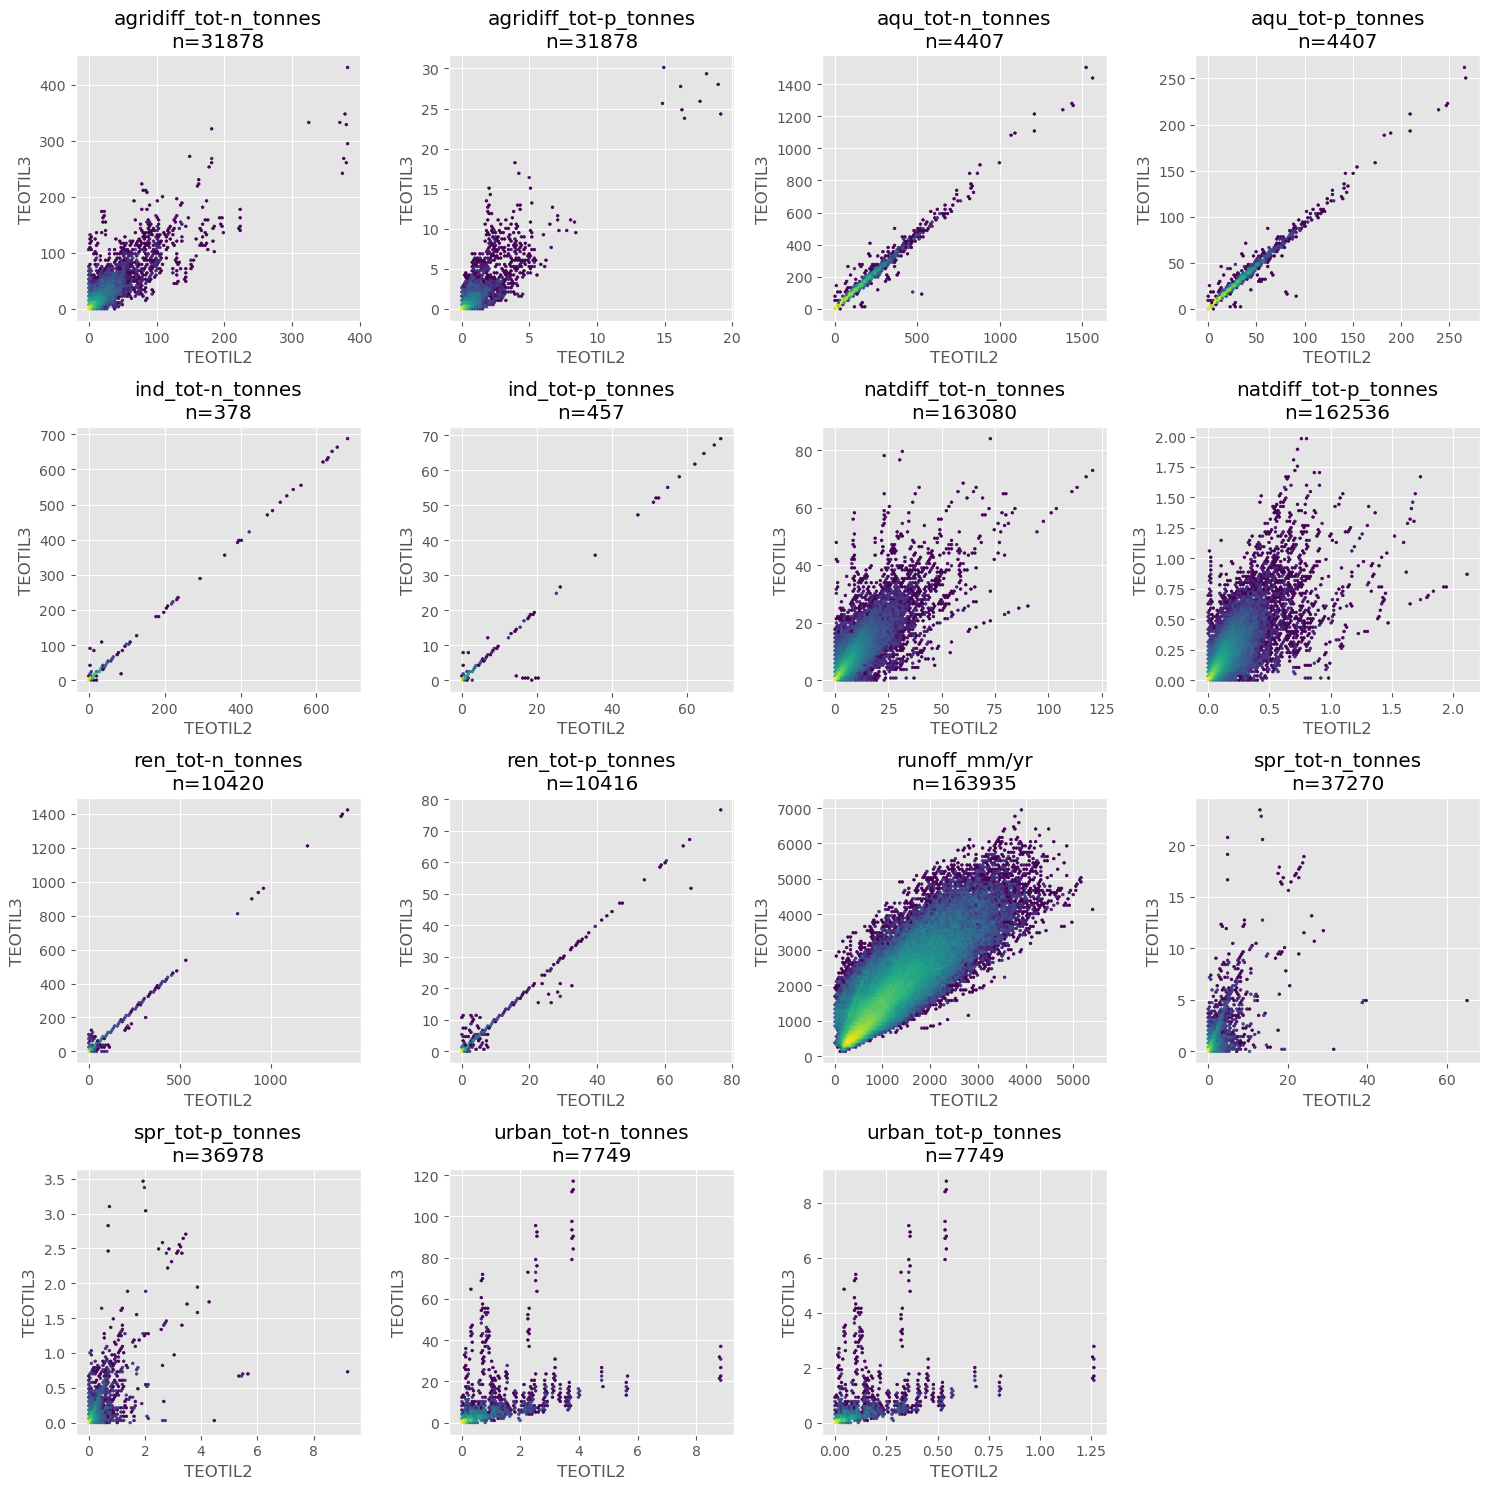

In [14]:
# Hexbin plots
grpd_dfs = match_df.groupby("variable")
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()
plt.delaxes(ax=axes[-1])
for idx, (var, grp_df) in enumerate(grpd_dfs):
    axes[idx].hexbin(grp_df["old"], grp_df["new"], bins="log")
    axes[idx].set_title(f"{var}\nn={len(grp_df)}")
    axes[idx].set_xlabel("TEOTIL2")
    axes[idx].set_ylabel("TEOTIL3")
plt.tight_layout()

Some points to note based on the plots above:

 * Input estimates for the point sources (aquaculture, industry and wastewater) are all very similar between TEOTIL2 and TEOTIL3, which is good because both models use the same underlying data
 
 * Background diffuse inputs (`natdiff`) are low in the new model compared to the old one. I'm not sure whether this is reasonable, but I think the calculations are correct based on the spatially interpolated national lake survey from 2019 (see notebooks for [Task 2.7](https://github.com/NIVANorge/teotil3/tree/main/notebooks/development#task-27-improve-workflow-for-non-agricultural-diffuse-inputs))
 
 * Runoff is typically higher in TEOTIL3 than in the old model. I believe this is correct and that the low estimates in the old model are due to problems with NVE's discharge simulations (see above and the issue [here](https://github.com/NIVANorge/teotil3/issues/15) for details)
 
 * The new model predicts substantially higher (~5 times higher) fluxes from urban areas than the old model. The new model uses estimates from [Åstebøl et al. (2012)](https://www.miljodirektoratet.no/sharepoint/downloaditem?id=01FM3LD2XYMQWENJOBOVEL2YIHX3PUTEYP), which should be better than the old model, but it would be nice to check whether these estimates are reasonable. See the issue [here](https://github.com/NIVANorge/teotil3/issues/13)
 
 * The spredt results are surprisingly different, as the methodology hasn't changed significantly and both old and new estimates are based on the same underlying data from SSB. However, the code below shows that the total annual amount of spredt matches very closely between the old and new input datasets. I am therefore fairly sure that the code is working as expected, and that differences are due to changes in the agricultural area in the new AR50 dataset compared to the land cover data used by TEOTIL2

In [15]:
# Get total annual spredt for TEOTIL2 and TEOTIL3
year = 2021
display(
    teo2_df.query("year == @year").groupby("variable").sum(numeric_only=True)[["old"]]
)
display(df.query("year == @year").groupby("variable").sum(numeric_only=True)[["new"]])

,old
variable,
agridiff_tot-n_tonnes,3.096083e+04
agridiff_tot-p_tonnes,1.038351e+03
aqu_tot-n_tonnes,7.083802e+04
aqu_tot-p_tonnes,1.221365e+04
ind_tot-n_tonnes,2.641010e+03
ind_tot-p_tonnes,3.038419e+02
natdiff_tot-n_tonnes,6.124668e+04
natdiff_tot-p_tonnes,1.156474e+03
ren_tot-n_tonnes,1.578498e+04


,new
variable,
agridiff_tot-n_tonnes,4.690303e+04
agridiff_tot-p_tonnes,1.697944e+03
aqu_tot-n_tonnes,6.683535e+04
aqu_tot-p_tonnes,1.163746e+04
ind_tot-n_tonnes,2.369527e+03
ind_tot-p_tonnes,1.914989e+02
natdiff_tot-n_tonnes,5.977686e+04
natdiff_tot-p_tonnes,1.589401e+03
ren_tot-n_tonnes,1.589268e+04


### 3.2. Compare input data for specific catchments

The code below performs the following comparison for specific regines:

 * Compares model input for runoff, TOTN and TOTP to those from the old TEOTIL2 model
 * Plots time series for the new model to check patterns seem sensible
 
**Note:** The TEOTIL2 results use slightly different NVE discharge series, which introduces some noise, but this does not seem to be a major source of discrepancy compared to the difference in methodology.

In [16]:
def compare_regine_series(reg_id, match_df, comp_year):
    """ """
    comp_df = match_df.query("(regine == @reg_id) and (year == @comp_year)").copy()
    comp_df = comp_df.melt(id_vars=["regine", "year", "variable"], var_name="model")
    comp_df.sort_values("variable", inplace=True)

    sn.catplot(
        data=comp_df,
        x="model",
        y="value",
        col="variable",
        col_wrap=5,
        kind="bar",
        sharey=False,
        order=["old", "new"],
        height=2,
        aspect=1.5,
    )

    return comp_df


def summarise_regine_series(reg_id, df, log_y=False):
    reg_df = df.query("regine == @reg_id").sort_values("year").copy()
    reg_df[["source", "par_unit"]] = reg_df["variable"].str.split("_", n=1, expand=True)
    display(reg_df.groupby(["source", "par_unit"]).mean(numeric_only=True)[["new"]])

    g = sn.relplot(
        data=reg_df,
        x="year",
        y="new",
        col="par_unit",
        hue="source",
        col_wrap=3,
        kind="line",
        marker="o",
        facet_kws={"sharey": False, "sharex": True},
    )
    if log_y:
        g.set(yscale="log")

    return reg_df

#### 3.2.1. An urban-dominated catchment in Oslo

The new natural coefficients for this area are very similar to those used in the original model. However, the new urban coefficients from Åstebøl et al. (2012) yield substantially higher fluxes than the old model. Otherwise, the relative ordering of the inputs seems reasonable: `natural` is approximately an order of magnitude smaller than `urban`, and the runoff values are comparable.

new
source   par_unit                
agridiff tot-n_tonnes    0.057861
         tot-p_tonnes    0.008304
aqu      tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
ind      tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
natdiff  tot-n_tonnes    0.689207
         tot-p_tonnes    0.020010
ren      tot-n_tonnes    0.001167
         tot-p_tonnes    0.000156
runoff   mm/yr         493.111111
spr      tot-n_tonnes    0.005111
         tot-p_tonnes    0.000433
urban    tot-n_tonnes    9.751944
         tot-p_tonnes    0.731411

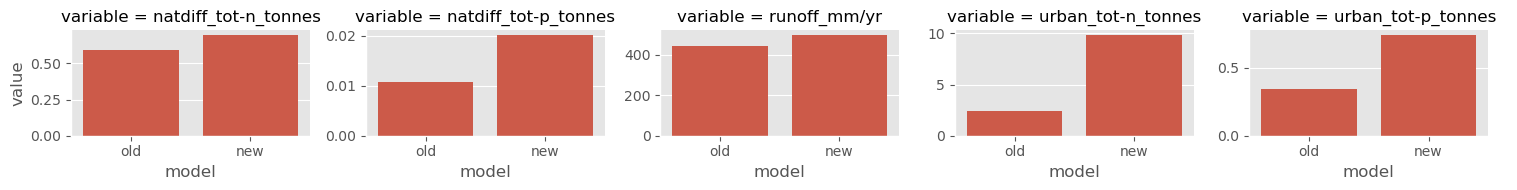

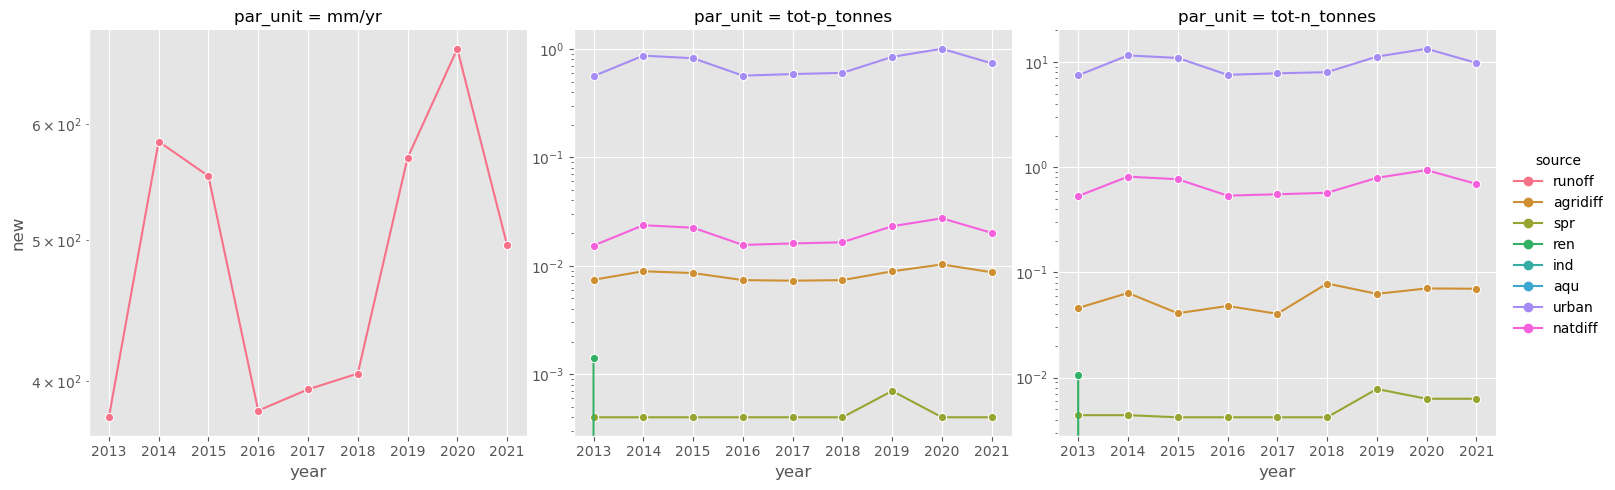

In [17]:
comp_year = 2021
reg_id = "006.A1Z"
comp_df = compare_regine_series(reg_id, match_df, comp_year)
reg_df = summarise_regine_series(reg_id, df, log_y=True)

### 3.2.2. A mountain catchment in Jotunheimen

The basic fluxes seem reasonable, but note that the new coefficients for woodland and upland based on the 2019 "1000 Lakes" survey are substantially lower than those used in the original model in this part of Norway. As a result, the new model predicts lower fluxes than TEOTIL2.

new
source   par_unit                 
agridiff tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
aqu      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
ind      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
natdiff  tot-n_tonnes     0.933422
         tot-p_tonnes     0.038111
ren      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
runoff   mm/yr         1606.444444
spr      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
urban    tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000

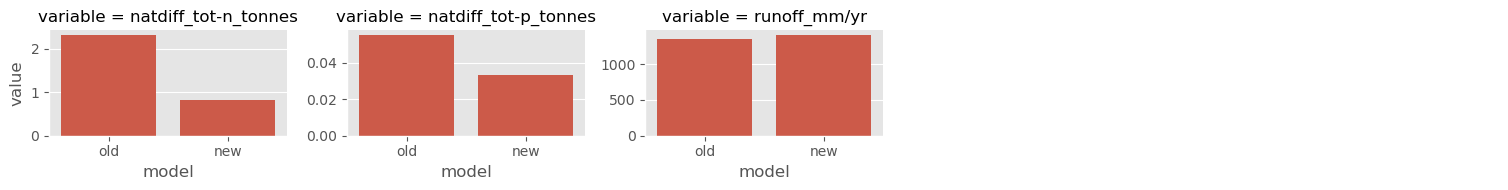

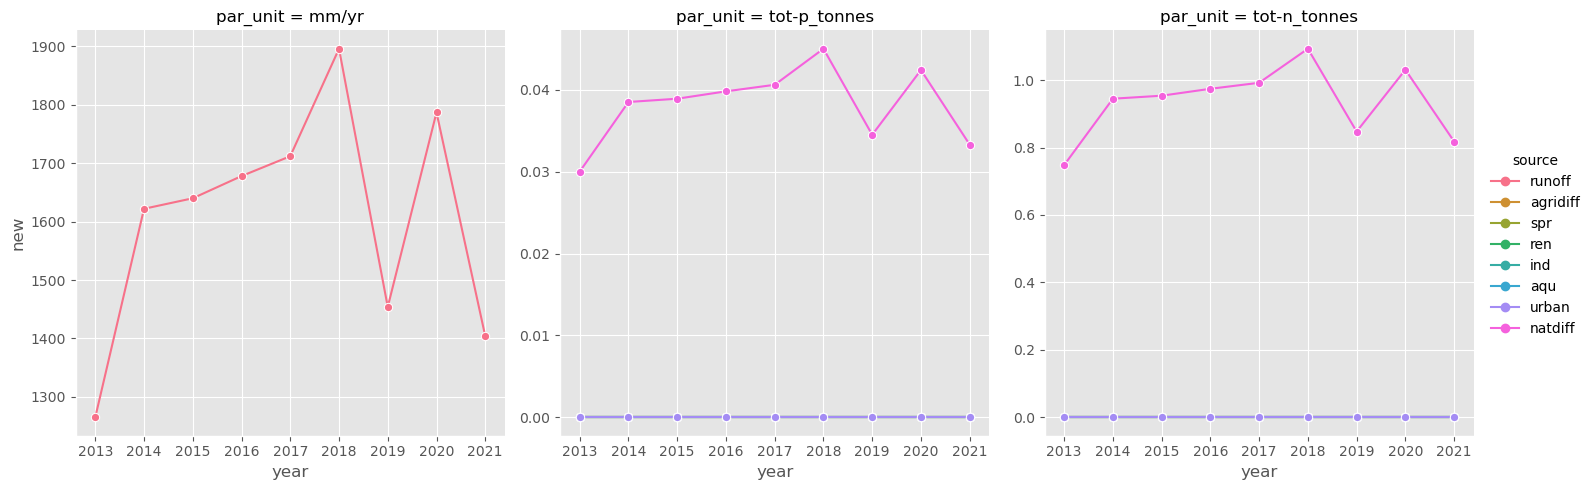

In [18]:
comp_year = 2021
reg_id = "075.BC1B"
comp_df = compare_regine_series(reg_id, match_df, comp_year)
reg_df = summarise_regine_series(reg_id, df, log_y=False)

### 3.2.3. An upland catchment in Finnmark

In this case, the new coefficients for `natural` are a bit smaller than those used in the old model, but the differences are not as large as in the southwest. Overall input fluxes are broadly comparable.

new
source   par_unit                
agridiff tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
aqu      tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
ind      tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
natdiff  tot-n_tonnes    6.974744
         tot-p_tonnes    0.168511
ren      tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
runoff   mm/yr         410.222222
spr      tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
urban    tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000

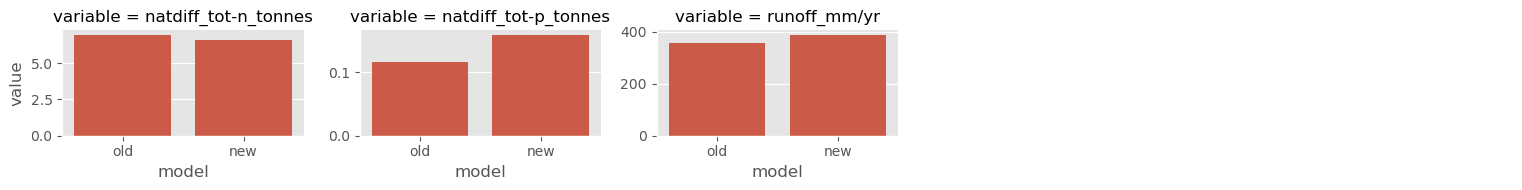

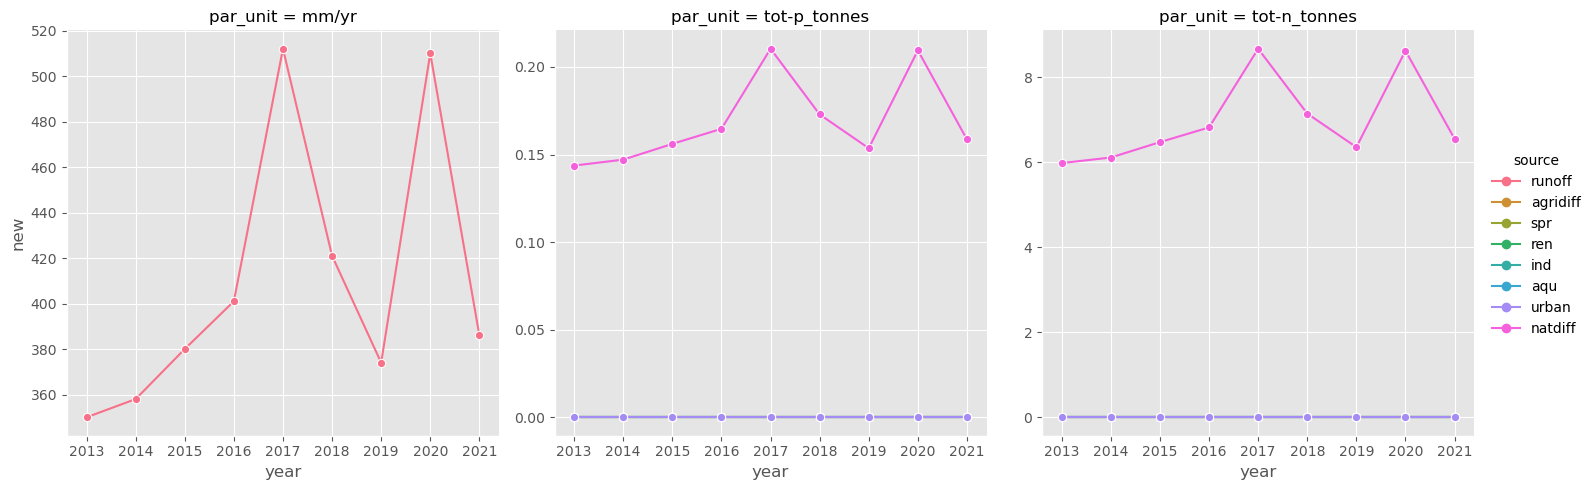

In [19]:
comp_year = 2021
reg_id = "234.GBB1Z"
comp_df = compare_regine_series(reg_id, match_df, comp_year)
reg_df = summarise_regine_series(reg_id, df, log_y=False)

### 3.2.4. A forested catchment in Sørlandet

Again, the `natural` fluxes in the new model are a little lower than in TEOTIL2, but they are nevertheless comparable. For urban, the old model uses coarser land cover data that does not identify any urban areas within this catchment, whereas AR50 identifies a very small `urban` area (which in this case is the shooting range above Flakk near Birkeland, which is not really urban).

new
source   par_unit                 
agridiff tot-n_tonnes     1.777025
         tot-p_tonnes     0.046066
aqu      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
ind      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
natdiff  tot-n_tonnes    20.948614
         tot-p_tonnes     0.353354
ren      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
runoff   mm/yr         1236.555556
spr      tot-n_tonnes     0.197189
         tot-p_tonnes     0.016522
urban    tot-n_tonnes     0.035200
         tot-p_tonnes     0.002644

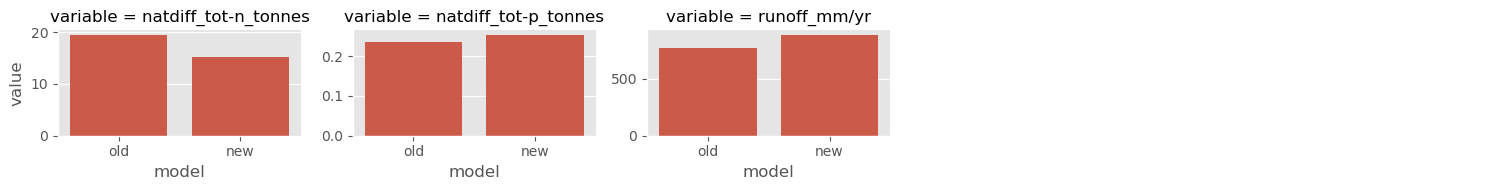

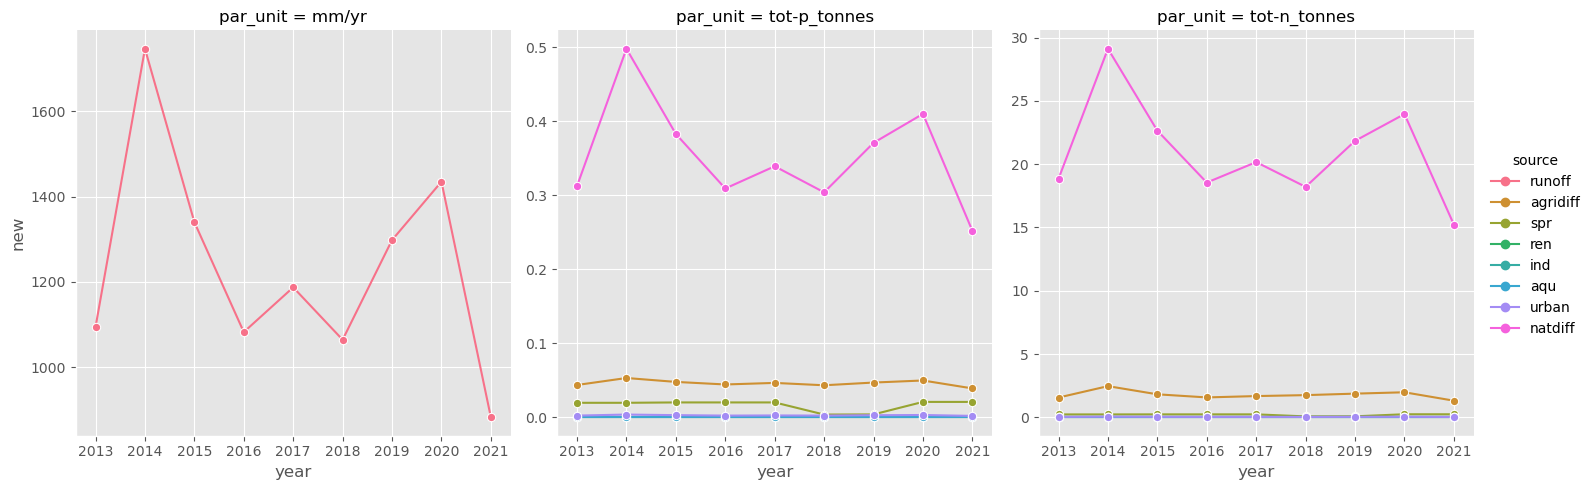

In [20]:
comp_year = 2021
reg_id = "020.AZ"
comp_df = compare_regine_series(reg_id, match_df, comp_year)
reg_df = summarise_regine_series(reg_id, df, log_y=False)

### 3.2.5. An industrial catchment in Grenland

new
source   par_unit                
agridiff tot-n_tonnes    5.912141
         tot-p_tonnes    0.213817
aqu      tot-n_tonnes    0.000000
         tot-p_tonnes    0.000000
ind      tot-n_tonnes  612.677333
         tot-p_tonnes    5.443000
natdiff  tot-n_tonnes    3.413360
         tot-p_tonnes    0.080458
ren      tot-n_tonnes   36.469133
         tot-p_tonnes    0.449856
runoff   mm/yr         723.666667
spr      tot-n_tonnes    1.070789
         tot-p_tonnes    0.147300
urban    tot-n_tonnes   17.992822
         tot-p_tonnes    1.349456

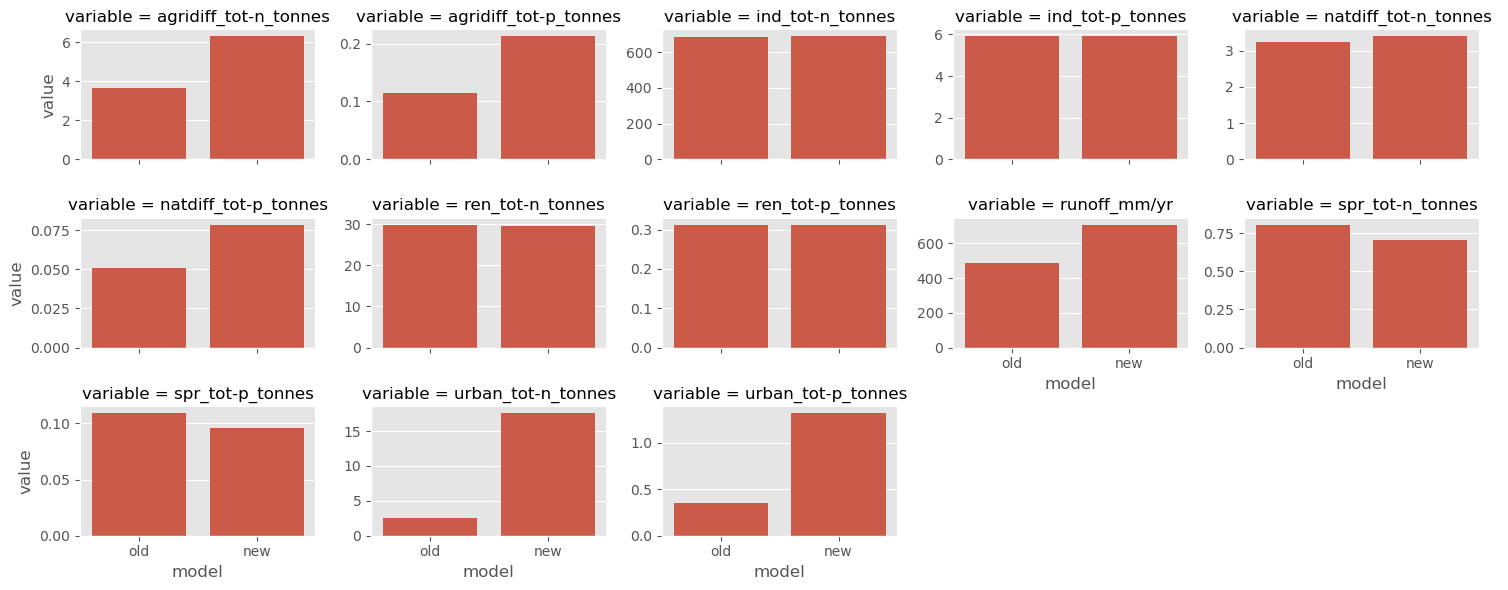

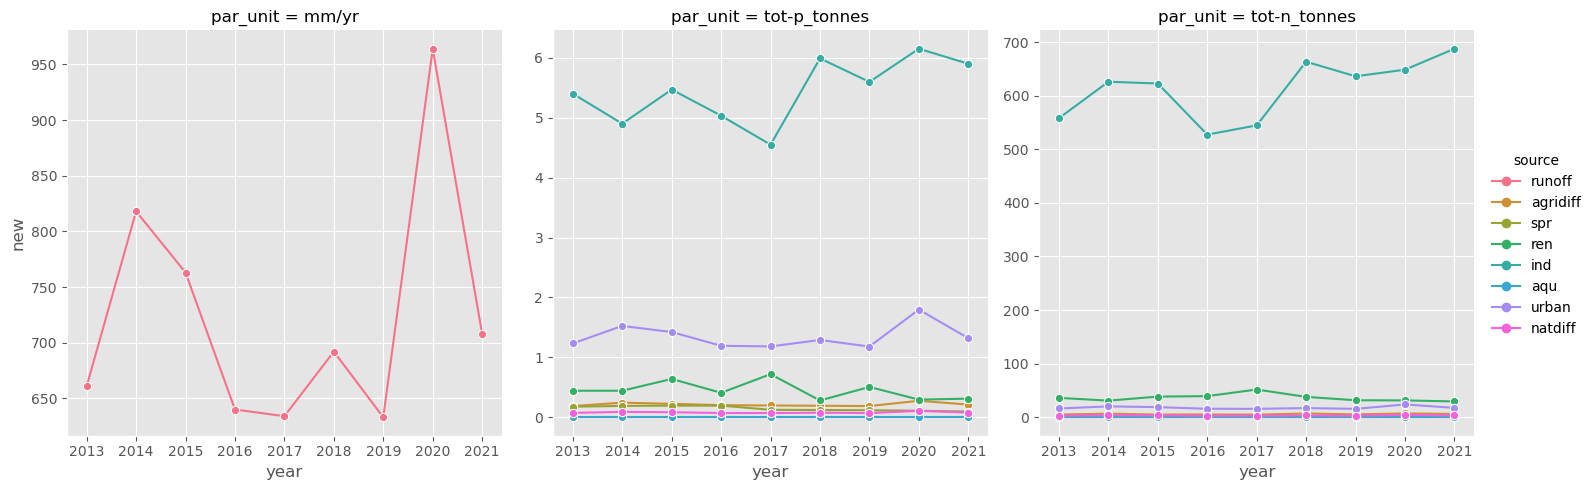

In [21]:
comp_year = 2021
reg_id = "016.32"
comp_df = compare_regine_series(reg_id, match_df, comp_year)
reg_df = summarise_regine_series(reg_id, df, log_y=False)

### 3.2.6. An aquaculture-dominated catchment in western Norway

new
source   par_unit                 
agridiff tot-n_tonnes     6.138687
         tot-p_tonnes     0.477987
aqu      tot-n_tonnes    40.258422
         tot-p_tonnes     7.009856
ind      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
natdiff  tot-n_tonnes     5.109710
         tot-p_tonnes     0.189662
ren      tot-n_tonnes     0.000000
         tot-p_tonnes     0.000000
runoff   mm/yr         1663.444444
spr      tot-n_tonnes     0.800700
         tot-p_tonnes     0.120122
urban    tot-n_tonnes     0.163778
         tot-p_tonnes     0.012278

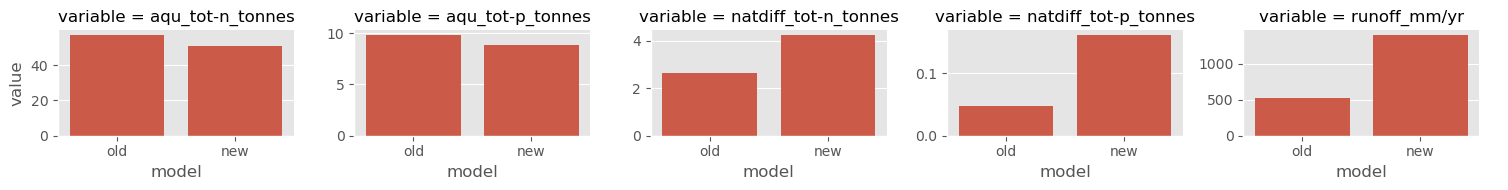

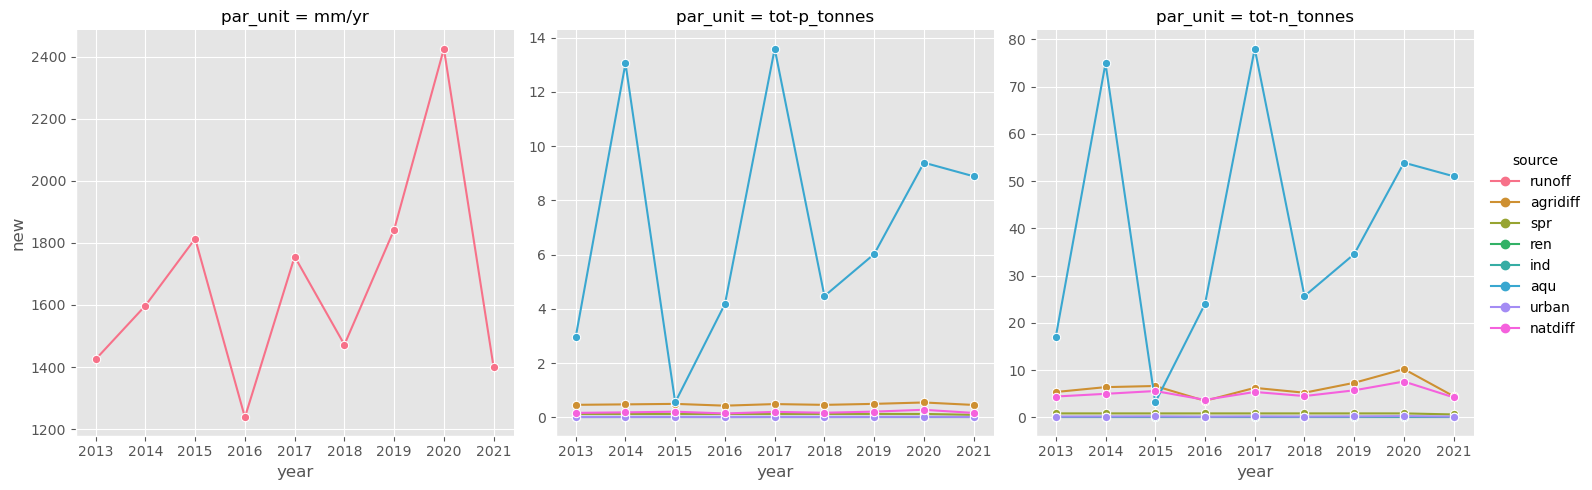

In [22]:
comp_year = 2021
reg_id = "177.74"
comp_df = compare_regine_series(reg_id, match_df, comp_year)
reg_df = summarise_regine_series(reg_id, df, log_y=False)

### 3.3. Input comparison summary

 * The new data files for non-agricultural diffuse inputs are superficially plausible, and show the expected spatial and temporal patterns
 * Results are broadly compatible with those from TEOTIL2, with the exception that:
   * The new model estimates much higher inputs from urban areas than the old one. This should be checked if possible - we may need to revise the values from Åstebøl et al. (2012)
   * The new coefficients for `natural` (`woodland` and `upland`) are generally lower than those used in the old model. This is especially true in South-western Norway; coefficients for South-eastern Norway seem very similar to those in TEOTIL2
   
As an additional point not shown in this notebook, further exploration suggests that the coefficients from Bogen (1996) predict very high sediment yields. It would be nice to find additional data to support these coefficients, as I'm not sure whether they are reasonable. I expect retention of sediment in lakes to be high, so perhaps the overall simulated fluxes will be reasonable once retention is taken into account. This should be revisited once the output from the new model can be compared to measured fluxes

## 4. Compare model results

In [23]:
############################################################################
# Set totals_from_subfracs=True below once all fractions are in the database
############################################################################

# Run TEOTIL3
years = range(st_yr, end_yr + 1)
df_list = []
for year in tqdm(years):
    csv_path = os.path.join(
        out_csv_fold,
        f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
    )
    g = teo.model.run_model(
        csv_path,
        id_col="regine",
        next_down_col="regine_down",
        totals_from_subfracs=True,
    )
    res_df = teo.model.model_to_dataframe(
        g, id_col="regine", next_down_col="regine_down"
    )
    res_df["year"] = year
    df_list.append(res_df)
df = pd.concat(df_list, axis="rows")
df.head()

  0%|          | 0/9 [00:00<?, ?it/s]

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.1A2B,001.1A2A,123.574401,0.752367,3.420677,6341.957239,68.505729,192.080130,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
1,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712746,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
2,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
3,001.221Z,001.2210,12.326813,68.074920,0.053138,258.939390,3.233008,15.559821,0.177127,0.123989,...,0.6,63.1,1527.1,1.2,17605.0,330.3,393.4,9.7,8.5,2013
4,001.222Z,001.2220,262.859191,2737.781710,1.843337,6137.673370,66.299361,329.158552,6.144458,4.301121,...,1.5,213.4,5387.1,4.1,59461.1,1118.4,1331.8,33.2,29.1,2013


In [24]:
# Convert column names and aggregate to match TEOTIL2
par_map = {
    "accum_q_m3/s": ["accum_q_m3/s"],
    "accum_aqu_tot-n_tonnes": ["accum_aquaculture_totn_kg"],
    "accum_aqu_tot-p_tonnes": ["accum_aquaculture_totp_kg"],
    "accum_agri_diff_tot-n_tonnes": ["accum_agriculture_totn_kg"],
    "accum_agri_diff_tot-p_tonnes": ["accum_agriculture_totp_kg"],
    "accum_ind_tot-n_tonnes": ["accum_industry_totn_kg"],
    "accum_ind_tot-p_tonnes": ["accum_industry_totp_kg"],
    "accum_nat_diff_tot-n_tonnes": [
        "accum_wood_totn_kg",
        "accum_upland_totn_kg",
        "accum_lake_din_kg",
        "accum_agriculture-background_totn_kg",
    ],
    "accum_nat_diff_tot-p_tonnes": [
        "accum_wood_totp_kg",
        "accum_upland_totp_kg",
        "accum_agriculture-background_totp_kg",
    ],
    "accum_ren_tot-n_tonnes": ["accum_large-wastewater_totn_kg"],
    "accum_ren_tot-p_tonnes": ["accum_large-wastewater_totp_kg"],
    "accum_spr_tot-n_tonnes": ["accum_spredt_totn_kg"],
    "accum_spr_tot-p_tonnes": ["accum_spredt_totp_kg"],
    "accum_urban_tot-n_tonnes": ["accum_urban_totn_kg"],
    "accum_urban_tot-p_tonnes": ["accum_urban_totp_kg"],
}
for key, val in par_map.items():
    if key == "accum_q_m3/s":
        df[key] = df[val].sum(axis="columns")
    else:
        df[key] = df[val].sum(axis="columns") / 1000
cols = ["regine", "year"] + list(par_map.keys())
df = df[cols]
df = df.melt(id_vars=["regine", "year"], value_name="new")
df.head()

,regine,year,variable,new
0,001.1A2B,2013,accum_q_m3/s,0.749662
1,001.1A4D,2013,accum_q_m3/s,0.129308
2,001.1M,2013,accum_q_m3/s,0.272519
3,001.221Z,2013,accum_q_m3/s,0.027203
4,001.222Z,2013,accum_q_m3/s,0.100927


In [25]:
# Get TEOTIL2 results
df_list = []
for year in range(st_yr, end_yr + 1):
    url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_output_data/teotil2_results_{year}.csv"
    teo2_df = pd.read_csv(url)
    teo2_df["year"] = year
    df_list.append(teo2_df)

teo2_df = pd.concat(df_list, axis="rows")
teo2_df = teo2_df[cols]
teo2_df = teo2_df.melt(id_vars=["regine", "year"], value_name="old")
teo2_df.head()

,regine,year,variable,old
0,001.1A2B,2013,accum_q_m3/s,0.403685
1,001.1A4D,2013,accum_q_m3/s,0.092123
2,001.1M,2013,accum_q_m3/s,0.178895
3,001.221Z,2013,accum_q_m3/s,0.016750
4,001.222Z,2013,accum_q_m3/s,0.061914


In [26]:
# Join
match_df2 = pd.merge(df, teo2_df, on=["regine", "year", "variable"], how="inner")[
    ["regine", "year", "variable", "old", "new"]
]
match_df2 = match_df2.query("(old != 0) and (new != 0)")
match_df2["variable"].replace(
    {
        "nat_diff_tot-n_tonnes": "natdiff_tot-n_tonnes",
        "nat_diff_tot-p_tonnes": "natdiff_tot-p_tonnes",
        "agri_diff_tot-n_tonnes": "agridiff_tot-n_tonnes",
        "agri_diff_tot-p_tonnes": "agridiff_tot-p_tonnes",
    },
    inplace=True,
)
print(len(match_df2))
match_df2.head()

898639


,regine,year,variable,old,new
0,001.1A2B,2013,accum_q_m3/s,0.403685,0.749662
1,001.1A4D,2013,accum_q_m3/s,0.092123,0.129308
2,001.1M,2013,accum_q_m3/s,0.178895,0.272519
3,001.221Z,2013,accum_q_m3/s,0.016750,0.027203
4,001.222Z,2013,accum_q_m3/s,0.061914,0.100927


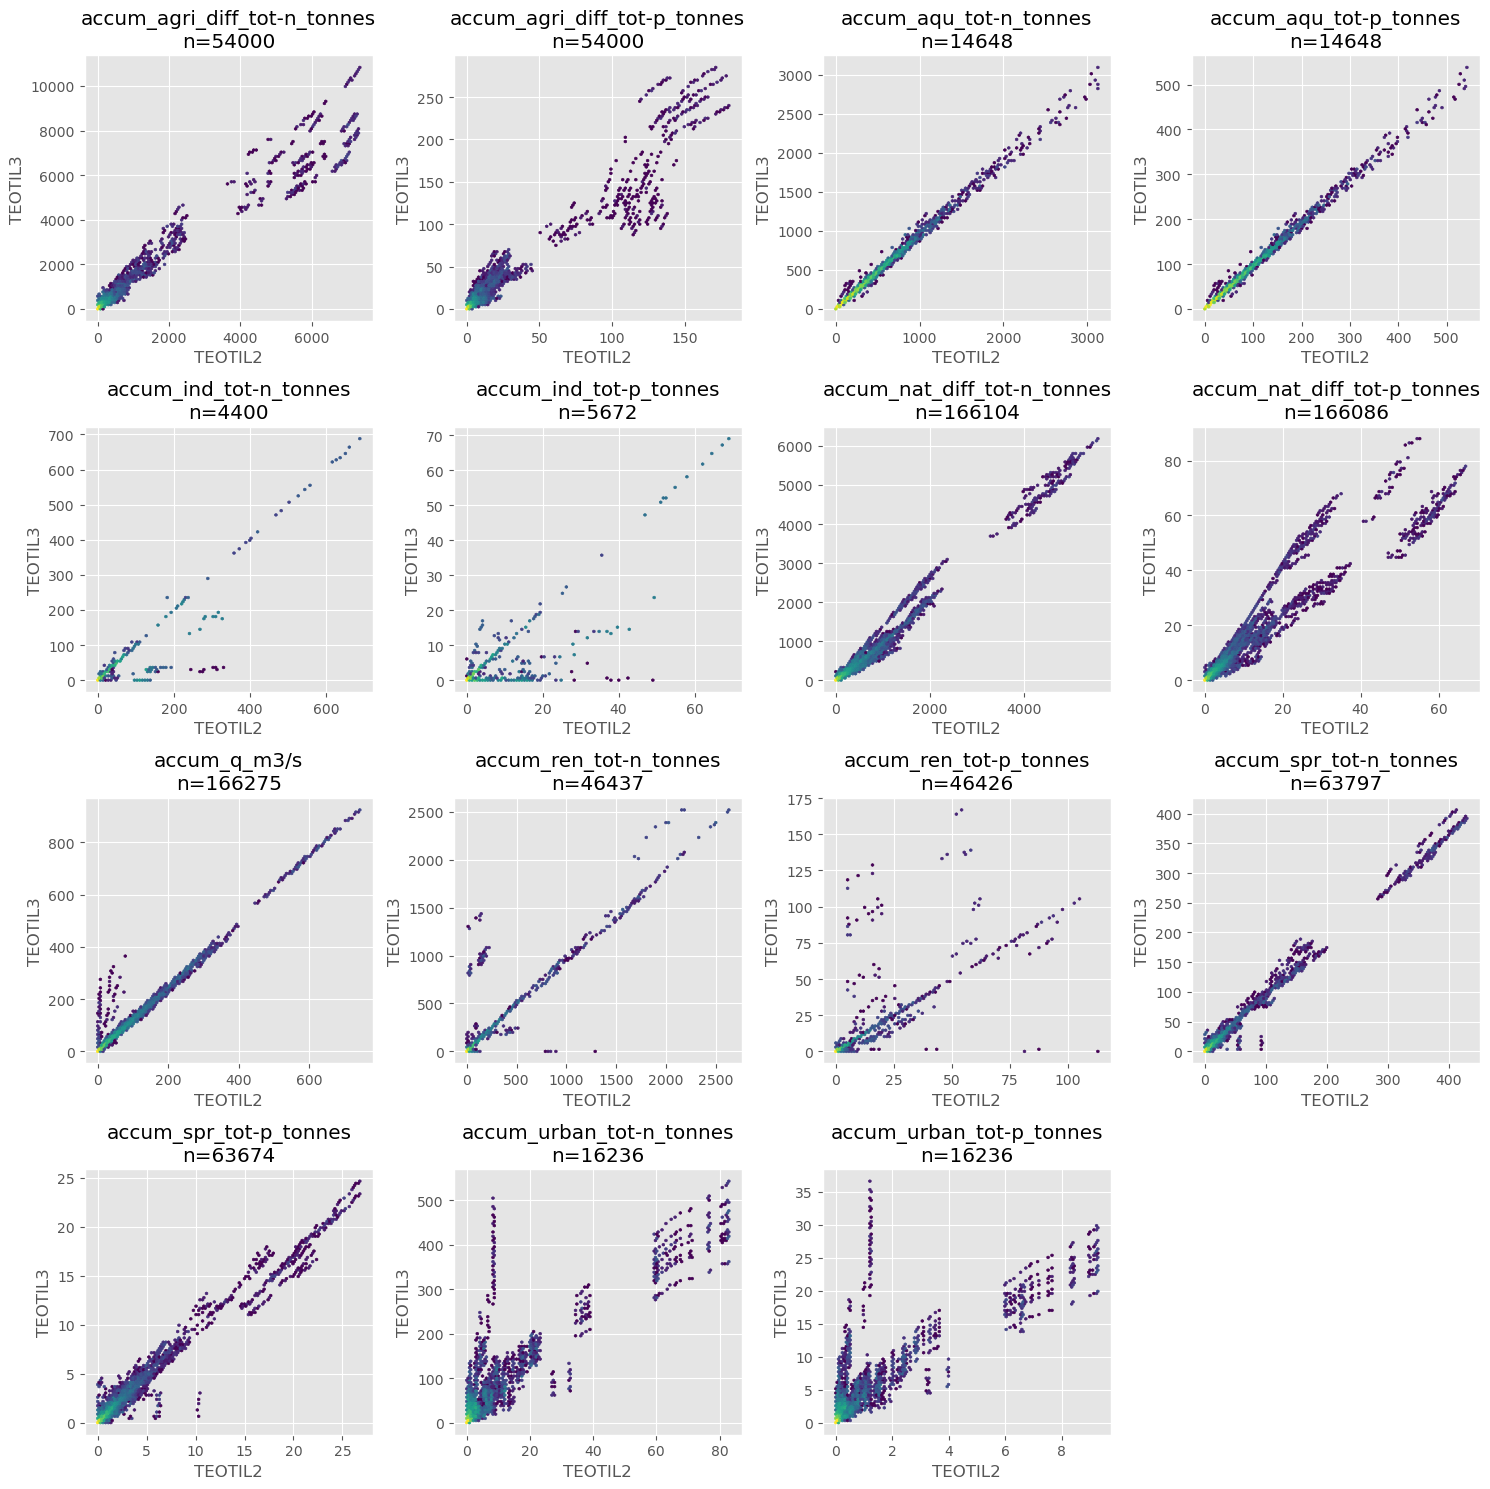

In [28]:
# Hexbin plots
grpd_dfs = match_df2.groupby("variable")
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()
plt.delaxes(ax=axes[-1])
for idx, (var, grp_df) in enumerate(grpd_dfs):
    axes[idx].hexbin(grp_df["old"], grp_df["new"], bins="log")
    axes[idx].set_title(f"{var}\nn={len(grp_df)}")
    axes[idx].set_xlabel("TEOTIL2")
    axes[idx].set_ylabel("TEOTIL3")
plt.tight_layout()

There is a generally positive correlation between the old and new model results - which is reassuring - but there are also some substantial differences. The most major differences seem to be caused by changes/additional options incorporated into the new algorithm for determining the catchment hierarchy. In the old model, coastal catchments were ordered sequentially, which resulted in fluxes being routed arbitrarily from river outflows along the coastline. In the new model, a new Boolean keyword argument, `order_coastal`, was introduced to allow users to control whether to keep the old behaviour or simply assign coastal catchments directly to the parent vassdragsområde (see [Section 2.1 of the notebook for Task 2.2](https://nbviewer.org/github/NIVANorge/teotil3/blob/main/notebooks/development/T2-2_catchment_hierarchy.ipynb#2.1.-Differences-compared-to-the-original-TEOTIL) for details). The recommended settings for the new model are to use `order_coastal=False`, in order to avoid the old model's unrealistic flow routing in the coastal zone. 

On the plots above, there are many examples where TEOTIL2 predicts large fluxes, whereas the TEOTIL3 fluxes are small or zero. In most cases, this seems to be due to the effects of the `order_coastal` parameter. As an example, consider the plot for `accum_q_m3/s` shown above. In most cases, there is a good linear relationship between the flows modelled in TEOTIL2 and TEOTIL3, which flows in the new model being generally higher than in TEOTIL2 (for reasons explained in Section 3, above). However, there are some some regines where the simulated TEOTIL2 flows are > 500 m3/s, whiles those in TEOTIL3 are essentially zero (see code below).

In [29]:
match_df2[match_df2["variable"] == "accum_q_m3/s"].query("new < 50 and old > 500").head(
    10
)

,regine,year,variable,old,new


These are all coastal regines, and in the old model the entire fluxes of water and nutrients from Glomma were routed first to the river outflow, and then through each of these regines. Instead, in the new model, the outflow of Glomma connects directly to vassdragsområde `002` and the coastal catchments are treated individually. This explains why there are cases where the old model simulates large fluxes but the new model simulates small ones.

In [30]:
match_df2.query("(variable == 'accum_aqu_tot-p_tonnes') and (old > 500)")

,regine,year,variable,old,new
361859,118.12,2014,accum_aqu_tot-p_tonnes,512.177242,471.3966
362397,118.110,2014,accum_aqu_tot-p_tonnes,538.389258,497.7312
362866,118.,2014,accum_aqu_tot-p_tonnes,538.389258,497.7312
435775,118.12,2018,accum_aqu_tot-p_tonnes,514.908715,468.9544
436313,118.110,2018,accum_aqu_tot-p_tonnes,535.517779,490.3639
436782,118.,2018,accum_aqu_tot-p_tonnes,535.517779,490.3639
472733,118.12,2020,accum_aqu_tot-p_tonnes,524.438556,501.5275
473271,118.110,2020,accum_aqu_tot-p_tonnes,534.483973,511.9357
473740,118.,2020,accum_aqu_tot-p_tonnes,534.483973,511.9357
491212,118.12,2021,accum_aqu_tot-p_tonnes,528.913254,525.6445
